In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=2)

In [2]:
from toolz import curry, compose, map, concat

In [3]:
import random

def shuffle(sequence, times=None, order=None):
    header, seq = sequence
    for i in range(times):
        kmers = [seq[i:i + order] for i in range(0, len(seq), order)]
        random.shuffle(kmers)
        seq_out = ''.join(kmers)
        yield header, seq_out
        
cshuffle = curry(shuffle)(times=10, order=2)
make_negative = compose(concat, curry(map)(cshuffle))

In [4]:
# import RNA sequences
from eden_rna.io.rfam import load
load_rfam = lambda rfam_id, num_seqs: load(rfam_id, seq_ids=range(num_seqs))

#fold sequence into a structure graph
from eden_rna.rnaplfold import fold
plfold_params = dict(window_size = 250,
                     max_bp_span = 150,
                     hard_threshold=0.5,
                     avg_bp_prob_cutoff = 0.3,
                     max_num_edges = 2,
                     no_lonely_bps=True,
                     nesting=True)
fold_plfold = curry(fold)(**plfold_params)

# map graphs to vectors
from eden.graph import vectorize
vec = curry(vectorize)(complexity=2, nbits=16)

In [5]:
import numpy as np
from scipy.sparse import vstack
from sklearn.linear_model import SGDClassifier

def make_classification_data(pos_fold, neg_fold, rfam_id, num_seqs):
    pos_data = pos_fold(rfam_id, num_seqs)
    neg_data = neg_fold(rfam_id, num_seqs)
    return pos_data, neg_data

def make_vector_dataset(data):
    pos_data, neg_data = data
    y = [1]*pos_data.shape[0] + [-1]*neg_data.shape[0]
    y = np.array(y)
    X = vstack((pos_data, neg_data))
    return X, y

def make_predictor(data):
    X, y = data
    predictor = SGDClassifier(average=True, class_weight='balanced', shuffle=True, n_jobs=-1)
    predictor.fit(X,y)
    return predictor

In [6]:
# parameters values
dim = 150
rfam_id = 'RF00005'

In [7]:
import numpy as np
from scipy.sparse import vstack
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer

def predictive_performance_estimate(data):
    X, y = data
    predictor = SGDClassifier(average=True, class_weight='balanced', shuffle=True, n_jobs=-1)
    cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=0)
    scoring = make_scorer(average_precision_score)
    scores = cross_val_score(predictor, X, y, cv=cv, scoring=scoring)
    return scores

def output(scores):
    print('AP: %.4f +- %.4f' % (np.mean(scores),np.std(scores)))

In [8]:
%%time
pos_fold = compose(vec, fold_plfold, load_rfam)
neg_fold = compose(vec, fold_plfold, make_negative, load_rfam)
make_data = curry(make_classification_data)(pos_fold, neg_fold)
ppe = compose(output, predictive_performance_estimate, make_vector_dataset, make_data)
ppe(rfam_id, dim)

AP: 0.7155 +- 0.0373
CPU times: user 25.6 s, sys: 5.68 s, total: 31.3 s
Wall time: 1min 15s


In [9]:
#display many graphs
from eden.display import draw_graph_set
draw_graph_set_params = dict(n_graphs_per_line=2,
                             size=9,
                             vertex_border=False,
                             vertex_size=200,
                             font_size=9,
                             vertex_alpha=0.6,
                             vertex_color='_label_',
                             colormap='Set3',
                             ignore_for_layout='nesting')
draw_graph_set_rna = curry(draw_graph_set)(**draw_graph_set_params)

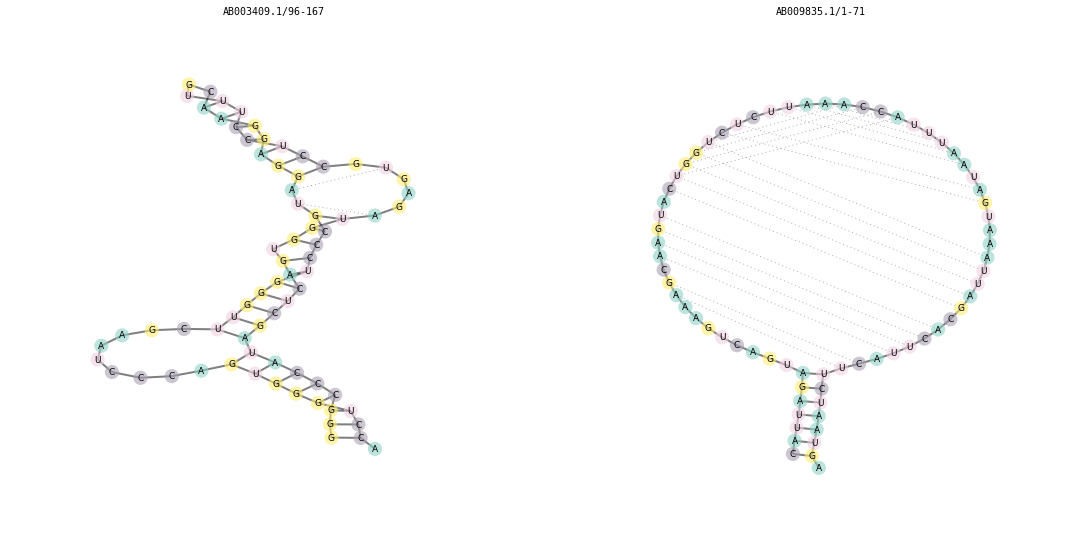

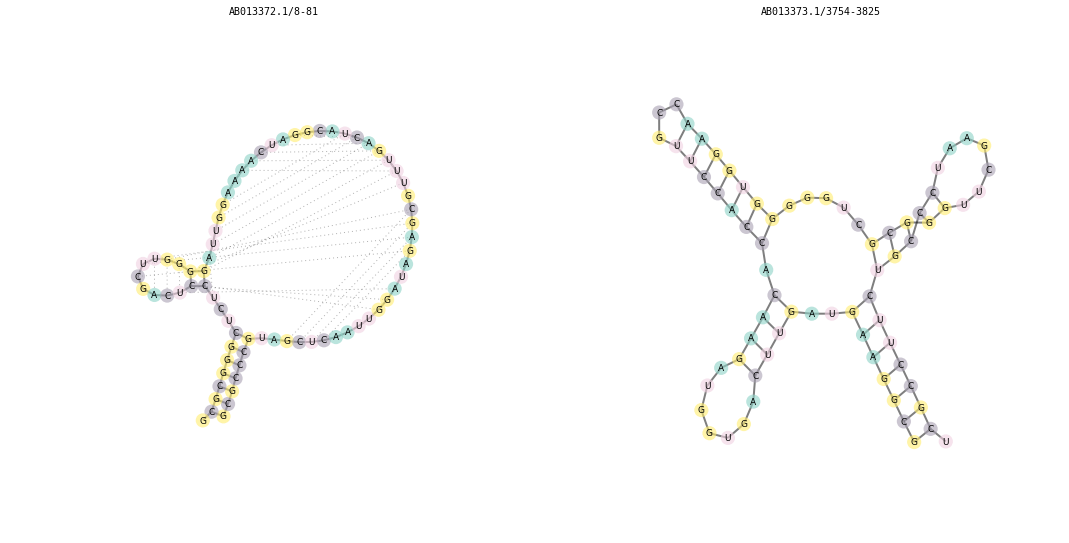

In [10]:
draw_structs = compose(draw_graph_set_rna, fold_plfold, load_rfam)
draw_structs(rfam_id, 4)

### change folding strategy

In [11]:
%%time
from eden_rna.rnafold import fold
pos_fold = compose(vec, fold, load_rfam)
neg_fold = compose(vec, fold, make_negative, load_rfam)
make_data = curry(make_classification_data)(pos_fold, neg_fold)
ppe = compose(output, predictive_performance_estimate, make_vector_dataset, make_data)
ppe(rfam_id, dim)

AP: 0.7372 +- 0.0392
CPU times: user 27.4 s, sys: 6.19 s, total: 33.6 s
Wall time: 1min 9s


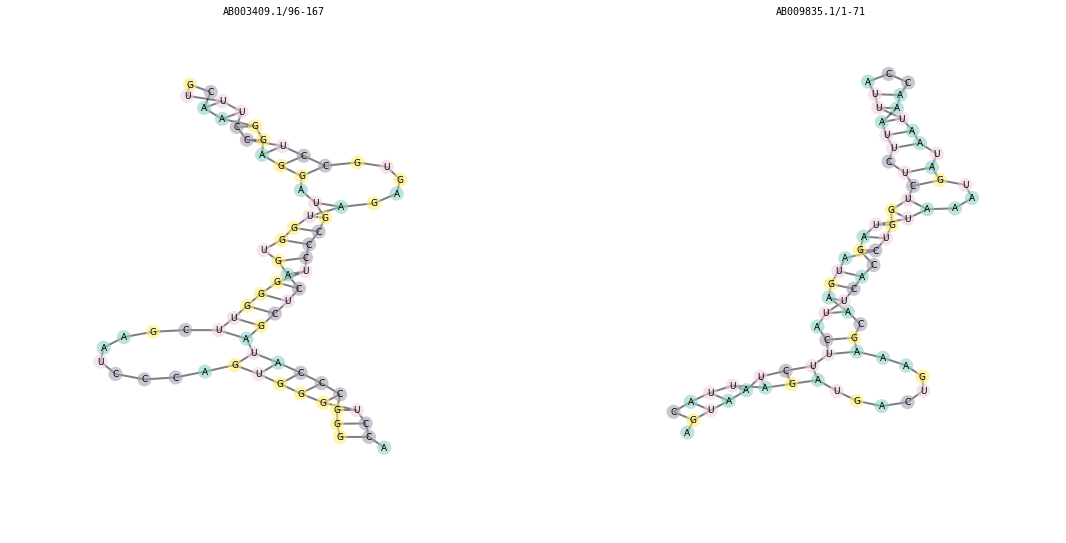

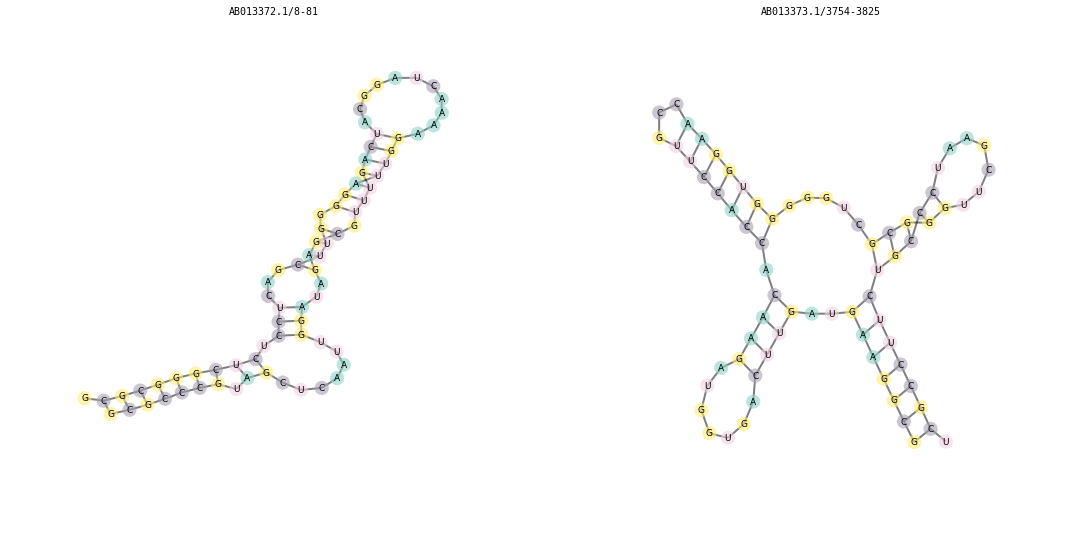

In [12]:
from eden_rna.rnafold import fold
draw_structs = compose(draw_graph_set_rna, fold, load_rfam)
draw_structs(rfam_id, 4)

---

### todo: iterate fit predictor and predict and select difficult seqs

In [13]:
pos_fold = compose(vec, fold_plfold, load_rfam)
neg_fold = compose(vec, fold_plfold, make_negative, load_rfam)
make_data = curry(make_classification_data)(pos_fold, neg_fold)
fit_predictor = compose(make_predictor, make_vector_dataset, make_data)

In [14]:
def select_difficult(estimator, data):
    data = list(data)
    preds = estimator.decision_function(data)
    instances = []
    for pred, instance in zip(preds, data):
        if -1>= pred <= 1 :
            instances.append(instance)
    return vstack(instances)

In [15]:
from eden_rna.rnafold import fold

estimator = fit_predictor(rfam_id, dim)
cselect_difficult = curry(select_difficult)(estimator)
neg_fold = compose(cselect_difficult, vec, fold, make_negative, load_rfam)

pos_fold = compose(vec, fold, load_rfam)
make_data = curry(make_classification_data)(pos_fold, neg_fold)
ppe = compose(output, predictive_performance_estimate, make_vector_dataset, make_data)
ppe(rfam_id, dim)

/Users/costa/anaconda/envs/eden_env/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: setting an array element with a sequence.

In [ ]:
#toolz.itertoolz.iterate(func, x)[source]
#Repeatedly apply a function func onto an original input
#Yields x, then func(x), then func(func(x)), then func(func(func(x))), etc..